# AutoEncoder for CIFAR10 using Convolutional Neural Network

## Importing the libraries

In [23]:
import sys
import os
%matplotlib inline
import math

import torch
from torch import nn
import random
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, sampler
import torchvision.datasets as dset

import torchvision

from matplotlib import pyplot as plt
from matplotlib import rcParams
from IPython import display
from ipywidgets import interact, widgets

import numpy as np


IMG_SIZE = 28
BATCH_SIZE = 128
EPOCHS = 40
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LATEST_EPOCH = 0

print(f"Device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")


Device: cuda
PyTorch version: 2.1.0+cu121


## Define dataset and dataloader

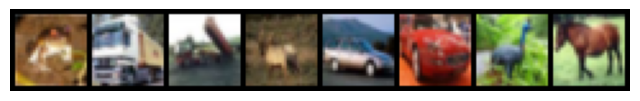

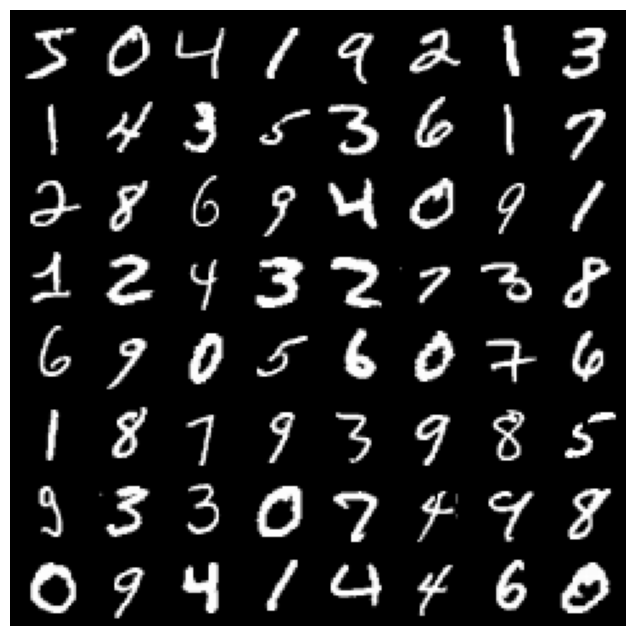

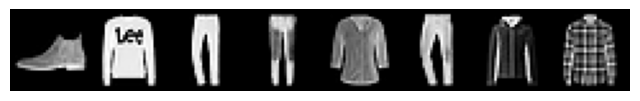

In [24]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



# CIFAR-10

cifar10_train = dset.CIFAR10(root='.', train=True, download=False, transform=transform)
cifar10_train_loader = DataLoader(cifar10_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)


cifar10_test = dset.CIFAR10(root='.', train=False, download=False, transform=transform)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=BATCH_SIZE)

images, labels = next(iter(DataLoader(cifar10_train, batch_size=8)))

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(torchvision.utils.make_grid(images.to(DEVICE)[:8], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# MNIST

mnist_dataset = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
mnist_test_dataset = torchvision.datasets.MNIST(root='.', train=False, download=True, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                          ]))

mnist_train_loader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


images, labels = next(iter(DataLoader(mnist_dataset, batch_size=64)))

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(torchvision.utils.make_grid(images.to(DEVICE)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Fashion MNIST

fashion_train = torchvision.datasets.FashionMNIST(root='.', train=True, download=False, transform=transforms.ToTensor())
fashion_test = torchvision.datasets.FashionMNIST(root='.', train=False, download=False, transform=transforms.ToTensor())

fashion_train_loader = DataLoader(fashion_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

fashion_test_loader = DataLoader(fashion_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)


images, labels = next(iter(DataLoader(fashion_test, batch_size=8)))

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(torchvision.utils.make_grid(images.to(DEVICE)[:8], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


## Define the model

In [12]:
from torchsummary import summary

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # Update input channel to 3
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),
            # nn.ReLU(),
            # nn.Conv2d(64, 128, 3, stride=2, padding=1)
        )
        # 解码器
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            # nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


def print_model_summary(model):
    print(model)
    print("Model Summary:")
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name} | Size: {param.size()} | Parameters: {param.numel()}")
            total_params += param.numel()
    print(f"Total Trainable Parameters: {total_params}")

autoencoder = Autoencoder()
# print_model_summary(autoencoder)

test_input = torch.randn(1, 3, 28, 28)
test_output = autoencoder(test_input)

print(f"Test Input Shape: {test_input.shape}")
print(f"Test Output Shape: {test_output.shape}")

summary(autoencoder.to(DEVICE), (3, 28, 28))

del autoencoder

Test Input Shape: torch.Size([1, 3, 28, 28])
Test Output Shape: torch.Size([1, 3, 28, 28])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             448
              ReLU-2           [-1, 16, 14, 14]               0
            Conv2d-3             [-1, 32, 7, 7]           4,640
              ReLU-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 64, 1, 1]         100,416
   ConvTranspose2d-6             [-1, 32, 7, 7]         100,384
              ReLU-7             [-1, 32, 7, 7]               0
   ConvTranspose2d-8           [-1, 16, 14, 14]           4,624
              ReLU-9           [-1, 16, 14, 14]               0
  ConvTranspose2d-10            [-1, 3, 28, 28]             435
          Sigmoid-11            [-1, 3, 28, 28]               0
Total params: 210,947
Trainable params: 210,947
Non-trainable params: 0
----

## Train the model

### Load model

In [3]:
import re


RE_MODEL = re.compile(r"autoencoder_cifar_epoch_(\d+).pth")
MODEL_NAME = "autoencoder_cifar"
LATEST_EPOCH = 0


def get_latest_model(path, re_model=RE_MODEL):
    files = os.listdir(path)
    latest_model = 0
    for file in files:
        match = RE_MODEL.match(file)
        if match:
            epoch = int(match.group(1))
            if epoch > latest_model:
                latest_model = epoch
    return latest_model



def load_model(model, optimizer, model_name, model_epoch=0):
    global LATEST_EPOCH
    re_model_name = model_name + "_epoch_" + str(model_epoch)
    if os.path.exists(re_model_name):
        checkpoint = torch.load(re_model_name)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        LATEST_EPOCH = checkpoint['epoch']
        print(f"Succecfully load model from {model_name}!")
        print(f"Latest model epoch: {LATEST_EPOCH}")
    else:
        print(f"Can't find model {model_name}, train from scratch!")


def save_model(model, optimizer, epoch, model_name):
    model_path = model_name + "_epoch_" + str(epoch)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, os.path.join(os.getcwd(), "Models", model_path))
    print(f"Succecfully save model to {model_path}!")

model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
LATEST_EPOCH = get_latest_model(os.getcwd())


# load_model(model, optimizer, MODEL_NAME, LATEST_EPOCH)

NameError: name 'Autoencoder' is not defined

### train model

In [5]:
from torch.utils.tensorboard import SummaryWriter

Writer = SummaryWriter(log_dir="./logs")


def train(model, device, train_loader, optimizer, criterion, epoch, print_every=10, writer=None):
        model.train()
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            if (batch_idx+1) % (len(train_loader)//print_every) == 0:
                print(f"Train Epoch: {epoch} [{(batch_idx+1) * len(data)}/{len(train_loader.dataset)} ({100. * (batch_idx+1) / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
            
        print(f"Train Epoch: {epoch} Average Loss: {total_loss/len(train_loader):.6f}")
        if Writer:
            Writer.add_scalar('Train/Loss', total_loss/len(train_loader), epoch)
        


def test(model, device, test_loader, criterion, epoch, writer=None):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output = model(data)
            test_loss += criterion(output, data).item()
    
    test_loss /= len(test_loader)
    print(f"Test Epoch: {epoch} Average Loss: {test_loss:.6f}")
    if Writer:
        Writer.add_scalar('Test/Loss', test_loss, epoch)


for epoch in range(LATEST_EPOCH+1, 21):
    train(model, DEVICE, cifar10_train_loader, optimizer, criterion, epoch, print_every=5)
    test(model, DEVICE, cifar10_test_loader, criterion, epoch)
    if (epoch+1) % 4 == 0:
        save_model(model, optimizer, epoch, "AutoEncoder_CIFAR10")

Train Epoch: 1 [9984/50000 (20%)]	Loss: 0.126103
Train Epoch: 1 [19968/50000 (40%)]	Loss: 0.166388
Train Epoch: 1 [29952/50000 (60%)]	Loss: 0.135064
Train Epoch: 1 [39936/50000 (80%)]	Loss: 0.115682
Train Epoch: 1 [49920/50000 (100%)]	Loss: 0.113557
Train Epoch: 1 Average Loss: 0.141951
Test Epoch: 1 Average Loss: 0.132684
Train Epoch: 2 [9984/50000 (20%)]	Loss: 0.125978
Train Epoch: 2 [19968/50000 (40%)]	Loss: 0.144755
Train Epoch: 2 [29952/50000 (60%)]	Loss: 0.154049
Train Epoch: 2 [39936/50000 (80%)]	Loss: 0.153223
Train Epoch: 2 [49920/50000 (100%)]	Loss: 0.102279
Train Epoch: 2 Average Loss: 0.135415
Test Epoch: 2 Average Loss: 0.132087
Train Epoch: 3 [9984/50000 (20%)]	Loss: 0.144287
Train Epoch: 3 [19968/50000 (40%)]	Loss: 0.138071
Train Epoch: 3 [29952/50000 (60%)]	Loss: 0.131417
Train Epoch: 3 [39936/50000 (80%)]	Loss: 0.111256
Train Epoch: 3 [49920/50000 (100%)]	Loss: 0.144079
Train Epoch: 3 Average Loss: 0.135135
Test Epoch: 3 Average Loss: 0.131976
Succecfully save model to

KeyboardInterrupt: 

## Visualize the results

### Visualize the original images and reconstructed images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

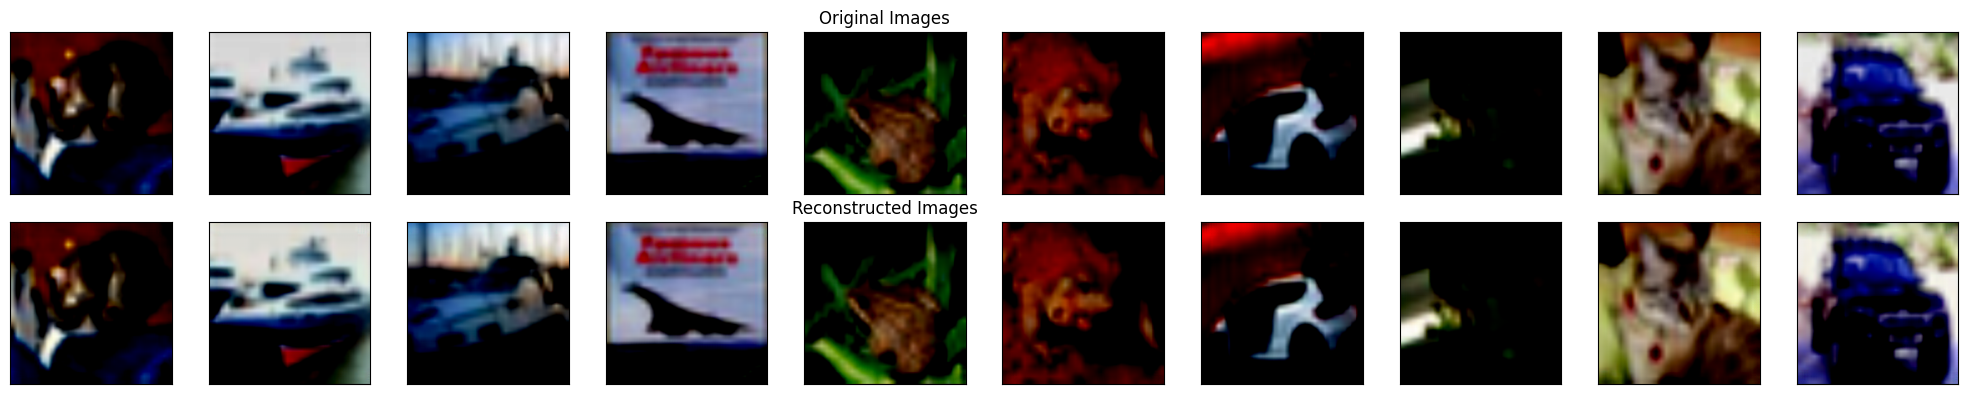

In [17]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def visualize_image(model, dataloader):
    model.eval()
    with torch.no_grad():
        for img, _ in dataloader:
            img = img.to(DEVICE)
            output = model(img)
            break

    fig, ax = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        img_orig = TF.resize(img[i], (IMG_SIZE, IMG_SIZE))
        img_recon = TF.resize(output[i], (IMG_SIZE, IMG_SIZE))
        ax[0, i].imshow(img_orig.cpu().permute(1, 2, 0), cmap='gray')
        ax[0, i].axes.get_xaxis().set_visible(False)
        ax[0, i].axes.get_yaxis().set_visible(False)
        ax[1, i].imshow(img_recon.cpu().permute(1, 2, 0), cmap='gray')
        ax[1, i].axes.get_xaxis().set_visible(False)
        ax[1, i].axes.get_yaxis().set_visible(False)
    # set title
    ax[0, 4].set_title('Original Images')
    ax[1, 4].set_title('Reconstructed Images')
    plt.tight_layout()
    plt.show()

visualize_image(model, cifar10_test_loader)


### tSNE analysis

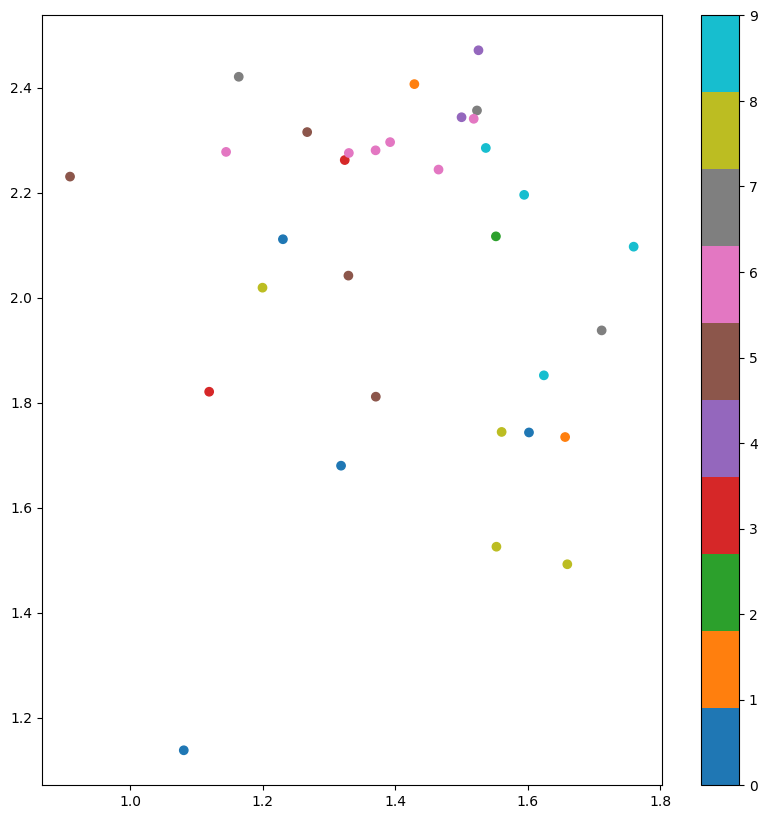

In [39]:
from sklearn.manifold import TSNE

def visualize_latent_space(model, dataloader):
    model.eval()
    with torch.no_grad():
        for img, labels in dataloader:
            img = img.to(DEVICE)
            output = model.encoder(img)
            break
    
    output = output.cpu().numpy()
    labels = labels.cpu().numpy()
    output = output.reshape(output.shape[0], -1)
    output_embedded = TSNE(n_components=2).fit_transform(output)
    plt.figure(figsize=(10, 10))
    plt.scatter(output_embedded[:, 0], output_embedded[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
    plt.show()

visualize_latent_space(model, cifar10_test_loader)

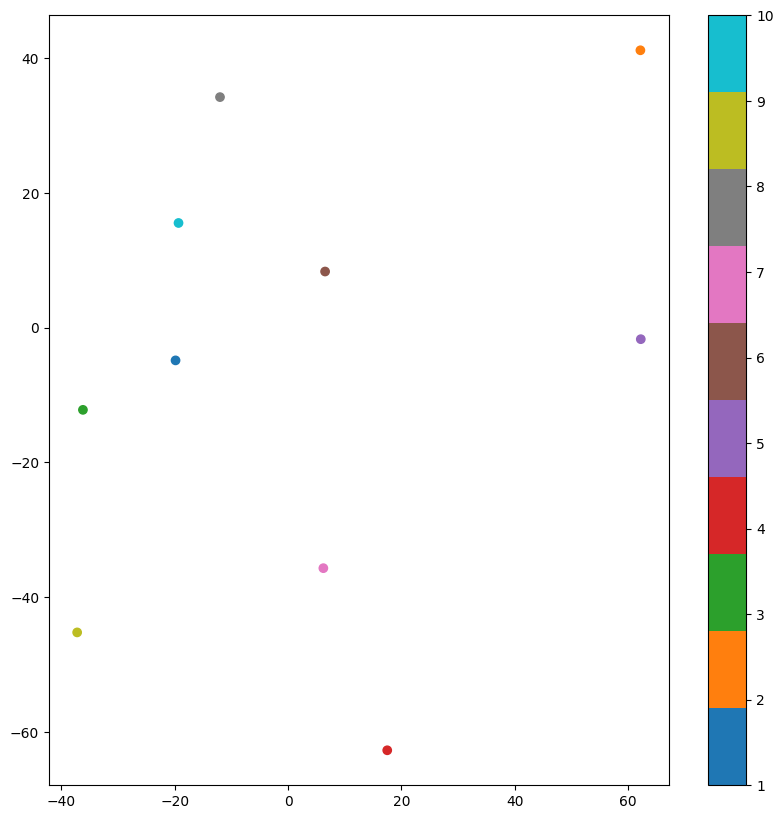

In [38]:

# viusalize the center of the latent space(mean)
def visualize_mean_image(model, dataloader):
    model.eval()
    with torch.no_grad():
        for img, labels in dataloader:
            img = img.to(DEVICE)
            output = model.encoder(img)
            break
    
    output = output.cpu().numpy()
    labels = labels.cpu().numpy()
    output = output.reshape(output.shape[0], -1)
    output_embedded = TSNE(n_components=2).fit_transform(output)
    plt.figure(figsize=(10, 10))
    mean = np.zeros((10, 2))
    for _ in range(10):
        mean[_] = np.mean(output_embedded[labels==_], axis=0)
    plt.scatter(mean[:, 0], mean[:, 1], c=list(range(1,11)), cmap='tab10')
    plt.colorbar()
    plt.show()

visualize_mean_image(model, cifar10_test_loader)

----------------------

# VAE for CIFAR10 using Convolutional Neural Network

## Define VAE

In [27]:
class VAE(nn.Module):
    def __init__(self, c_channels=3, h_dim=128, z_dim=128):
        super(VAE, self).__init__()
        self._cchannels = c_channels
        self._hidden_dim = h_dim
        self._latent_dim = z_dim
        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(self._cchannels, 16, 3, stride=2, padding=1),  # Update input channel to 3
            # [1,3,28,28] -> [1,16,14,14]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            # [1,16,14,14] -> [1,32,7,7]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7, stride=2, padding=1),
            # [1,32,7,7] -> [1,64,2,2]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, self._hidden_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(self._hidden_dim),
            # [1,64,2,2] -> [1,128,1,1]
        )
        # 解码器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self._hidden_dim, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 7, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, self._cchannels, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
        # 均值
        self.fc_mu = nn.Linear(self._hidden_dim, self._latent_dim)
        # 方差
        self.fc_var = nn.Linear(self._hidden_dim, self._latent_dim)
    
    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
        # [1, _latent_dim], [1, _latent_dim]
    
    def decode(self, z):
        z = z.view(-1, self._hidden_dim, 1, 1)  # Fix the input size of the decoder
        x = self.decoder(z)
        return x
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
        # [1, _latent_dim]
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x = self.decode(z)
        return x, mu, log_var

    def sample(self, num_samples=1):
        z = torch.randn(num_samples, self._latent_dim).to(DEVICE)
        samples = self.decode(z)
        return samples

# print_model_summary(VAE())

summary(VAE().to(DEVICE), (3, 28, 28))

test_input = torch.randn(BATCH_SIZE, 3, 28, 28)
test_output, test_mu, test_log_var = VAE()(test_input)

print(f"Test Input Shape: {test_input.shape}")
print(f"Test Output Shape: {test_output.shape}")
print(f"Test Mu Shape: {test_mu.shape}")
print(f"Test Log Var Shape: {test_log_var.shape}")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             448
       BatchNorm2d-2           [-1, 16, 14, 14]              32
              ReLU-3           [-1, 16, 14, 14]               0
            Conv2d-4             [-1, 32, 7, 7]           4,640
       BatchNorm2d-5             [-1, 32, 7, 7]              64
              ReLU-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 64, 2, 2]         100,416
       BatchNorm2d-8             [-1, 64, 2, 2]             128
              ReLU-9             [-1, 64, 2, 2]               0
           Conv2d-10            [-1, 128, 1, 1]          73,856
      BatchNorm2d-11            [-1, 128, 1, 1]             256
           Linear-12                  [-1, 128]          16,512
           Linear-13                  [-1, 128]          16,512
  ConvTranspose2d-14             [-1, 6

## Train the model


In [28]:
from torch.utils.tensorboard import SummaryWriter

def trainVAE(model, device, train_loader, optimizer, criterion, epoch, print_every=10, writer=None):
    model.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output, mu, log_var = model(data)
        loss = criterion(output, data, mu, log_var)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (batch_idx+1) % (len(train_loader)//print_every) == 0:
            print(f"Train Epoch: {epoch} [{(batch_idx+1) * len(data)}/{len(train_loader.dataset)} ({100. * (batch_idx+1) / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

    print(f"Train Epoch: {epoch} Average Loss: {total_loss/len(train_loader):.6f}")
    if writer:
        writer.add_scalar('Train/Loss', total_loss/len(train_loader), epoch)


def testVAE(model, device, test_loader, criterion, epoch, writer=None):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output, mu, log_var = model(data)
            test_loss += criterion(output, data, mu, log_var).item()

    test_loss /= len(test_loader)
    print(f"Test Epoch: {epoch} Average Loss: {test_loss:.6f}")
    if writer:
        writer.add_scalar('Test/Loss', test_loss, epoch)


def loss_FnVAE(recon_x, x, mu, log_var):
    # BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return MSE + KLD


# CIFAR-10
# VAE_model = VAE().to(DEVICE)
# VAE_criterion = loss_FnVAE
# VAE_optimizer = torch.optim.Adam(VAE_model.parameters(), lr=0.01)
# VAE_NAME = "VAE_cifar"
# RE_VAE = re.compile(r"VAE_cifar_epoch_(\d+).pth")
# torch.cuda.synchronize()  # Synchronize CUDA operations
# VAE_LATEST_EPOCH = get_latest_model(os.getcwd(), RE_VAE)
# Writer = SummaryWriter(log_dir="./logs/VAE")


# # load_model(VAE_model, VAE_optimizer, VAE_criterion, VAE_NAME, VAE_LATEST_EPOCH)

# for epoch in range(LATEST_EPOCH+1, 41):
#     trainVAE(VAE_model, DEVICE, cifar10_train_loader, VAE_optimizer, VAE_criterion, epoch, print_every=5, writer=Writer)
#     testVAE(VAE_model, DEVICE, cifar10_test_loader, VAE_criterion, epoch, writer=Writer)
#     if (epoch+1) % 4 == 0:
#         save_model(VAE_model, VAE_optimizer, epoch, VAE_NAME)

# Writer.close()

# Fashion MNIST
VAE_model = VAE(1,128,128).to(DEVICE)
VAE_criterion = loss_FnVAE
VAE_optimizer = torch.optim.Adam(VAE_model.parameters(), lr=0.01)
RE_VAE = re.compile(r"VAE_cifar_epoch_(\d+).pth")
torch.cuda.synchronize()  # Synchronize CUDA operations
VAE_LATEST_EPOCH = get_latest_model(os.getcwd(), RE_VAE)
Writer = SummaryWriter(log_dir="./logs/VAE/FASHION_MNIST")


# load_model(VAE_model, VAE_optimizer, VAE_criterion, VAE_NAME, VAE_LATEST_EPOCH)

for epoch in range(LATEST_EPOCH+1, 41):
    trainVAE(VAE_model, DEVICE, fashion_train_loader, VAE_optimizer, VAE_criterion, epoch, print_every=5, writer=Writer)
    testVAE(VAE_model, DEVICE, fashion_test_loader, VAE_criterion, epoch, writer=Writer)
    if (epoch+1) % 4 == 0:
        save_model(VAE_model, VAE_optimizer, epoch, "VAE_FASHION_MNIST")

Writer.close()

Train Epoch: 1 [11904/60000 (20%)]	Loss: 5172.468750
Train Epoch: 1 [23808/60000 (40%)]	Loss: 4556.296875
Train Epoch: 1 [35712/60000 (59%)]	Loss: 3946.593262
Train Epoch: 1 [47616/60000 (79%)]	Loss: 3852.724121
Train Epoch: 1 [59520/60000 (99%)]	Loss: 3739.704346
Train Epoch: 1 Average Loss: 4827.844330
Test Epoch: 1 Average Loss: 3629.359769
Train Epoch: 2 [11904/60000 (20%)]	Loss: 3760.093262
Train Epoch: 2 [23808/60000 (40%)]	Loss: 3553.914062
Train Epoch: 2 [35712/60000 (59%)]	Loss: 3694.263672
Train Epoch: 2 [47616/60000 (79%)]	Loss: 3464.724609
Train Epoch: 2 [59520/60000 (99%)]	Loss: 3479.710205
Train Epoch: 2 Average Loss: 3593.739848
Test Epoch: 2 Average Loss: 3460.637467
Train Epoch: 3 [11904/60000 (20%)]	Loss: 3329.823242
Train Epoch: 3 [23808/60000 (40%)]	Loss: 3636.148682
Train Epoch: 3 [35712/60000 (59%)]	Loss: 3361.412598
Train Epoch: 3 [47616/60000 (79%)]	Loss: 3586.828613
Train Epoch: 3 [59520/60000 (99%)]	Loss: 3665.837158
Train Epoch: 3 Average Loss: 3469.078967
Te

## Test the model

torch.Size([10, 3, 28, 28])


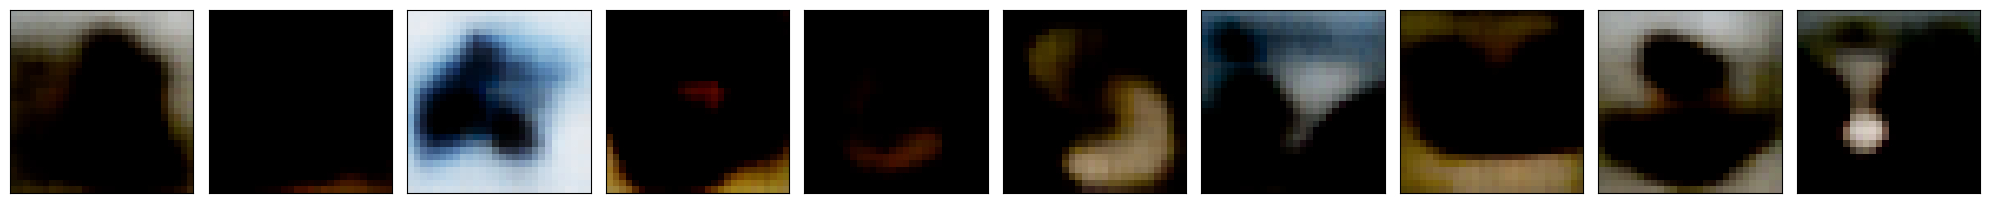

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 28, 28]) torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


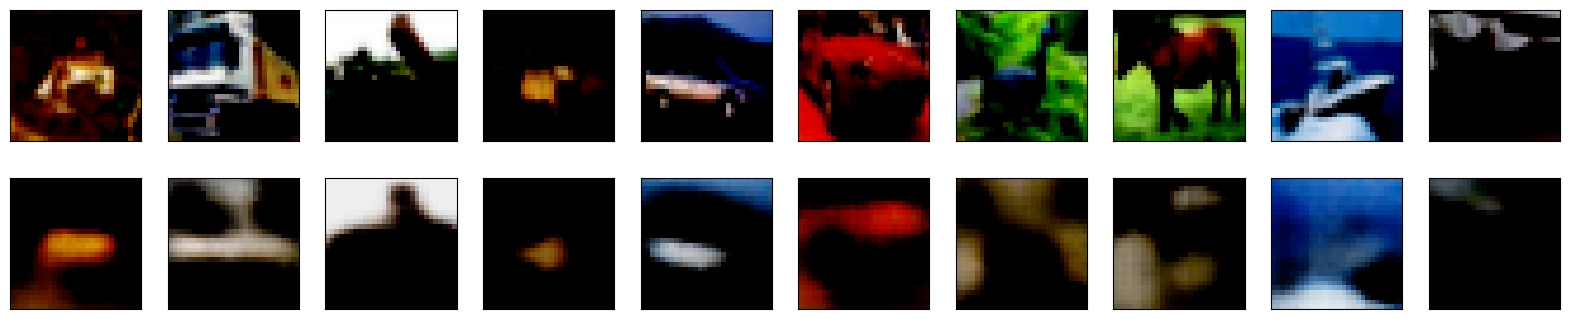

In [30]:
VAE_model.eval()
with torch.no_grad():
    samples = VAE_model.sample(10)
    print(samples.shape)

    fig, ax = plt.subplots(1, 10, figsize=(20, 4))
    for i in range(10):
        img = samples[i]
        ax[i].imshow(img.cpu().permute(1, 2, 0), cmap='gray')
        ax[i].axes.get_xaxis().set_visible(False)
        ax[i].axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

image, label = next(iter(DataLoader(cifar10_train, batch_size=10)))
print(image.shape, label.shape)
with torch.no_grad():
    outputs, mu, log_var = VAE_model(image.to(DEVICE))

    fig, ax = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        img = image[i]
        ax[0, i].imshow(img.cpu().permute(1, 2, 0), cmap='gray')
        ax[0, i].axes.get_xaxis().set_visible(False)
        ax[0, i].axes.get_yaxis().set_visible(False)
        img = outputs[i]
        ax[1, i].imshow(img.cpu().permute(1, 2, 0), cmap='gray')
        ax[1, i].axes.get_xaxis().set_visible(False)
        ax[1, i].axes.get_yaxis().set_visible(False)


torch.Size([10, 1, 28, 28])


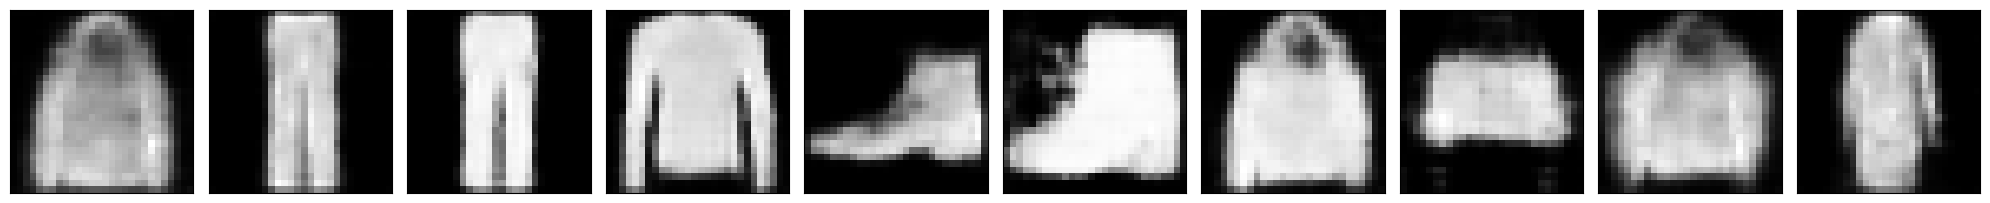

torch.Size([10, 1, 28, 28]) torch.Size([10])


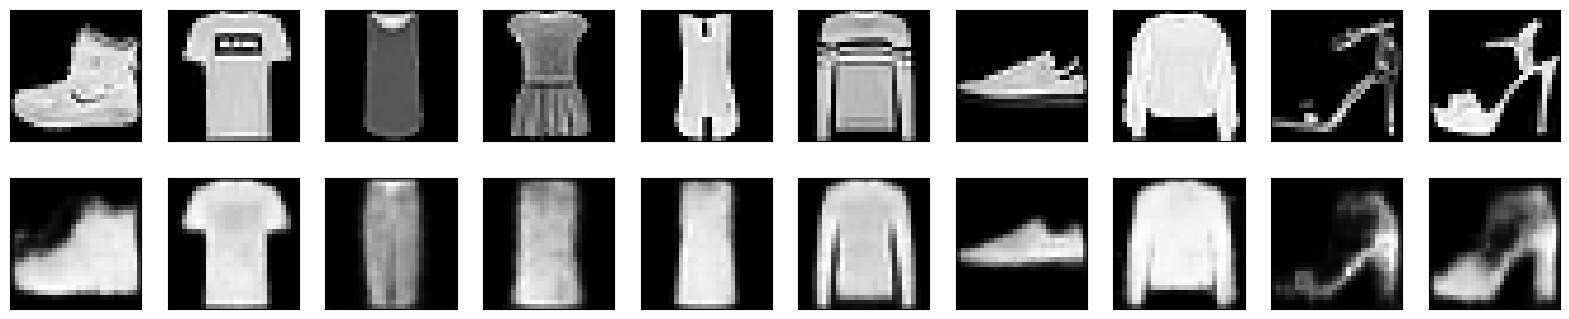

In [35]:
VAE_model.eval()
with torch.no_grad():
    samples = VAE_model.sample(10)
    print(samples.shape)

    fig, ax = plt.subplots(1, 10, figsize=(20, 4))
    for i in range(10):
        img = samples[i]
        ax[i].imshow(img.cpu().permute(1, 2, 0), cmap='gray')
        ax[i].axes.get_xaxis().set_visible(False)
        ax[i].axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

image, label = next(iter(DataLoader(fashion_train, batch_size=10)))
print(image.shape, label.shape)
with torch.no_grad():
    outputs, mu, log_var = VAE_model(image.to(DEVICE))

    fig, ax = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        img = image[i]
        ax[0, i].imshow(img.cpu().permute(1, 2, 0), cmap='gray')
        ax[0, i].axes.get_xaxis().set_visible(False)
        ax[0, i].axes.get_yaxis().set_visible(False)
        img = outputs[i]
        ax[1, i].imshow(img.cpu().permute(1, 2, 0), cmap='gray')
        ax[1, i].axes.get_xaxis().set_visible(False)
        ax[1, i].axes.get_yaxis().set_visible(False)

# WGAN for MNIST using Convolutional Neural Network

## Define WGAN

### Define Generator

In [30]:
from torchsummary import summary

class Generator(nn.Module):

    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        
        self.z_dim = z_dim
        
        self.gen = nn.Sequential(
            
            self.get_generator_block(z_dim, 
                                     hidden_dim * 4,
                                     kernel_size=3, 
                                     stride=2),
            
            self.get_generator_block(hidden_dim * 4, 
                                     hidden_dim * 2,
                                     kernel_size=4,
                                     stride = 1),
            
            self.get_generator_block(hidden_dim * 2,
                                     hidden_dim ,
                                     kernel_size=3,
                                     stride = 2,
                                    ),

            self.get_generator_final_block(hidden_dim,
                                           im_chan,
                                           kernel_size=4,
                                           stride=2)
            

        )
        
        
    def get_generator_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace=True),
        )
    
    
    def get_generator_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.Tanh()
            )
    
    
    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)
    
    
    
summary(Generator(100).to(DEVICE), (100,))
print(Generator(100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         230,656
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 830,785
Trainable params: 830,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

### Define Critic

In [31]:
class Critic(nn.Module):

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            self.get_critic_block(im_chan,
                                         hidden_dim * 4,
                                         kernel_size=4,
                                         stride=2),
            
            self.get_critic_block(hidden_dim * 4,
                                         hidden_dim * 8,
                                         kernel_size=4,
                                         stride=2,),
            
            self.get_critic_final_block(hidden_dim * 8,
                                               1,
                                               kernel_size=4,
                                               stride=2,),

        )

        
    def get_critic_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
        )
    
    
    def get_critic_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
            )
    
    def forward(self, image):
        return self.disc(image)
    
summary(Critic().to(DEVICE) , (1,28,28))
print(Critic())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 13, 13]           1,088
       BatchNorm2d-2           [-1, 64, 13, 13]             128
         LeakyReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4            [-1, 128, 5, 5]         131,200
       BatchNorm2d-5            [-1, 128, 5, 5]             256
         LeakyReLU-6            [-1, 128, 5, 5]               0
            Conv2d-7              [-1, 1, 1, 1]           2,049
Total params: 134,721
Trainable params: 134,721
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.51
Estimated Total Size (MB): 0.84
----------------------------------------------------------------
Critic(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2,

## Train WGAM

### Optimizer

In [32]:
from torchvision.utils import make_grid


netG = Generator(100).to(DEVICE)
netD = Critic().to(DEVICE)

netG_opt = torch.optim.Adam(netG.parameters(), lr=0.002, betas=(0.5, 0.999))
netD_opt = torch.optim.Adam(netD.parameters(), lr=0.002, betas=(0.5, 0.999))



def gradient_penalty(critic, real, fake, device='cpu'):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)
    interpolated_images.requires_grad_(True)
    mixed_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def get_gen_loss(critic_fake_pred):
    return -torch.mean(critic_fake_pred)


def get_critic_loss(critic_fake_pred, critic_real_pred, gp, c_lambda):
    return torch.mean(critic_fake_pred) - torch.mean(critic_real_pred) + c_lambda * gp


def get_gradient(critic, real, fake, epsilon):
    mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_scores = critic(mixed_images)
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()



### train model


Epoch 1 | Batch 234/469(50%) | Critic Loss: -17.411828 | Generator Loss: -0.344913
Epoch 1 | Batch 468/469(100%) | Critic Loss: -55.879710 | Generator Loss: -10.926810
Epoch 1 | Critic Loss: -22.61632500675951, Generator Loss: -11.117430064469767
Epoch 2 | Batch 234/469(50%) | Critic Loss: -24.971167 | Generator Loss: 1.194361
Epoch 2 | Batch 468/469(100%) | Critic Loss: -3.599761 | Generator Loss: 24.030248
Epoch 2 | Critic Loss: -38.43450846056949, Generator Loss: 24.232916479807155
Epoch 3 | Batch 234/469(50%) | Critic Loss: -53.726396 | Generator Loss: 41.679322
Epoch 3 | Batch 468/469(100%) | Critic Loss: -119.815295 | Generator Loss: 84.270367
Epoch 3 | Critic Loss: -50.10688743258332, Generator Loss: 84.18750045345277
Epoch 4 | Batch 234/469(50%) | Critic Loss: -98.671745 | Generator Loss: 70.509567
Epoch 4 | Batch 468/469(100%) | Critic Loss: -2.675074 | Generator Loss: 132.628853
Epoch 4 | Critic Loss: -49.6279198116331, Generator Loss: 132.94215334503897
Epoch 5 | Batch 234/4

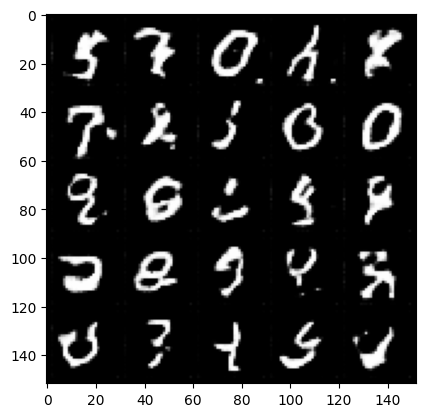

Succecfully save model to MNIST_Generator_epoch_9!
Succecfully save model to MNIST_Critic_epoch_9!
Epoch 10 | Batch 234/469(50%) | Critic Loss: -13.172227 | Generator Loss: 128.277140
Epoch 10 | Batch 468/469(100%) | Critic Loss: -9.659974 | Generator Loss: 256.619529
Epoch 10 | Critic Loss: -50.49626715010419, Generator Loss: 257.28202537788775
Epoch 11 | Batch 234/469(50%) | Critic Loss: -13.094213 | Generator Loss: 134.286691
Epoch 11 | Batch 468/469(100%) | Critic Loss: -65.806960 | Generator Loss: 257.875673
Epoch 11 | Critic Loss: -31.294986563044084, Generator Loss: 258.4321955063705
Epoch 12 | Batch 234/469(50%) | Critic Loss: -15.390576 | Generator Loss: 125.537371
Epoch 12 | Batch 468/469(100%) | Critic Loss: -3.718514 | Generator Loss: 252.389719
Epoch 12 | Critic Loss: -39.30367147541245, Generator Loss: 252.9974903994277
Epoch 13 | Batch 234/469(50%) | Critic Loss: -10.831283 | Generator Loss: 136.303981
Epoch 13 | Batch 468/469(100%) | Critic Loss: -34.553024 | Generator 

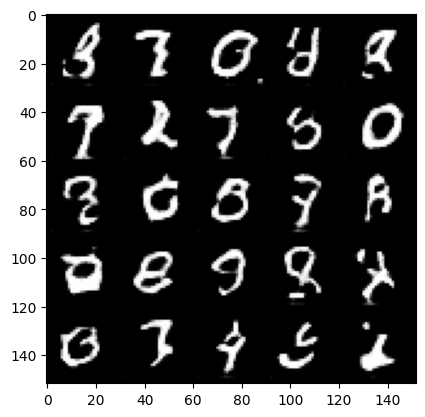

Succecfully save model to MNIST_Generator_epoch_19!
Succecfully save model to MNIST_Critic_epoch_19!
Epoch 20 | Batch 234/469(50%) | Critic Loss: 21.415503 | Generator Loss: 261.821923
Epoch 20 | Batch 468/469(100%) | Critic Loss: -19.751713 | Generator Loss: 537.692212
Epoch 20 | Critic Loss: -62.974790368964705, Generator Loss: 539.075909575928
Epoch 21 | Batch 234/469(50%) | Critic Loss: -80.244850 | Generator Loss: 294.089571
Epoch 21 | Batch 468/469(100%) | Critic Loss: -10.162662 | Generator Loss: 559.309820
Epoch 21 | Critic Loss: -80.89110678670761, Generator Loss: 560.680825028084
Epoch 22 | Batch 234/469(50%) | Critic Loss: -183.371109 | Generator Loss: 275.029367
Epoch 22 | Batch 468/469(100%) | Critic Loss: -24.055613 | Generator Loss: 506.100267
Epoch 22 | Critic Loss: -122.7116502086746, Generator Loss: 507.22228539472957
Epoch 23 | Batch 234/469(50%) | Critic Loss: -157.997919 | Generator Loss: 268.186995
Epoch 23 | Batch 468/469(100%) | Critic Loss: -52.537340 | Generat

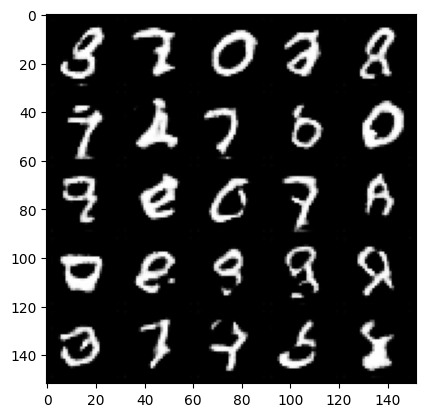

Succecfully save model to MNIST_Generator_epoch_29!
Succecfully save model to MNIST_Critic_epoch_29!
Epoch 30 | Batch 234/469(50%) | Critic Loss: -6.879397 | Generator Loss: 389.670467
Epoch 30 | Batch 468/469(100%) | Critic Loss: 3332.025636 | Generator Loss: 792.118908
Epoch 30 | Critic Loss: -30.753517063187658, Generator Loss: 793.9979974283083
Epoch 31 | Batch 234/469(50%) | Critic Loss: -62.542220 | Generator Loss: 415.488390
Epoch 31 | Batch 468/469(100%) | Critic Loss: -4.774563 | Generator Loss: 807.945435
Epoch 31 | Critic Loss: -85.7270325301807, Generator Loss: 809.5288854489191
Epoch 32 | Batch 234/469(50%) | Critic Loss: -15.267105 | Generator Loss: 427.069623
Epoch 32 | Batch 468/469(100%) | Critic Loss: 110.813672 | Generator Loss: 859.482469
Epoch 32 | Critic Loss: -82.40810731768865, Generator Loss: 860.8619749154616
Epoch 33 | Batch 234/469(50%) | Critic Loss: -13.812648 | Generator Loss: 442.258512
Epoch 33 | Batch 468/469(100%) | Critic Loss: -105.465060 | Generato

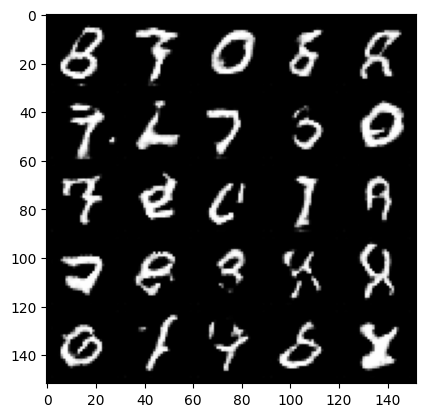

Succecfully save model to MNIST_Generator_epoch_39!
Succecfully save model to MNIST_Critic_epoch_39!
Epoch 40 | Batch 234/469(50%) | Critic Loss: -26.909337 | Generator Loss: 579.458884
Epoch 40 | Batch 468/469(100%) | Critic Loss: -78.286858 | Generator Loss: 1154.084957
Epoch 40 | Critic Loss: -18.361442049784962, Generator Loss: 1156.915417311289
Epoch 41 | Batch 234/469(50%) | Critic Loss: -138.817404 | Generator Loss: 564.553036
Epoch 41 | Batch 468/469(100%) | Critic Loss: -18.829565 | Generator Loss: 1171.340302
Epoch 41 | Critic Loss: -163.49622403950062, Generator Loss: 1174.115347791075
Epoch 42 | Batch 234/469(50%) | Critic Loss: -61.413943 | Generator Loss: 663.452606
Epoch 42 | Batch 468/469(100%) | Critic Loss: -7.347225 | Generator Loss: 1330.736745
Epoch 42 | Critic Loss: -107.4768063723151, Generator Loss: 1333.5821866053757
Epoch 43 | Batch 234/469(50%) | Critic Loss: -23.374077 | Generator Loss: 654.186883
Epoch 43 | Batch 468/469(100%) | Critic Loss: 1577.504065 | G

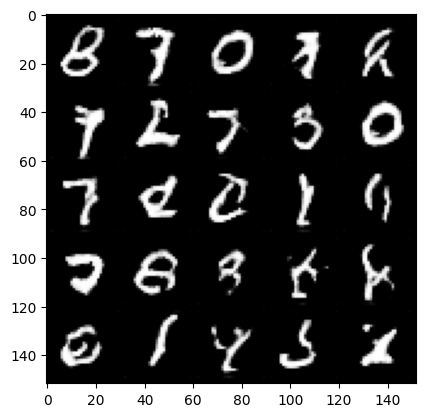

Succecfully save model to MNIST_Generator_epoch_49!
Succecfully save model to MNIST_Critic_epoch_49!
Epoch 50 | Batch 234/469(50%) | Critic Loss: -86.030326 | Generator Loss: 672.050970
Epoch 50 | Batch 468/469(100%) | Critic Loss: 86.884562 | Generator Loss: 1369.791678
Epoch 50 | Critic Loss: -188.1644659978748, Generator Loss: 1373.2738441028073
Epoch 51 | Batch 234/469(50%) | Critic Loss: 2.119831 | Generator Loss: 731.673405
Epoch 51 | Batch 468/469(100%) | Critic Loss: -61.042009 | Generator Loss: 1442.630458
Epoch 51 | Critic Loss: -90.22851146324867, Generator Loss: 1445.7004956080723
Epoch 52 | Batch 234/469(50%) | Critic Loss: -69.748114 | Generator Loss: 729.444490
Epoch 52 | Batch 468/469(100%) | Critic Loss: -54.275297 | Generator Loss: 1456.930334
Epoch 52 | Critic Loss: -138.51275568038923, Generator Loss: 1460.053924170129
Epoch 53 | Batch 234/469(50%) | Critic Loss: 15.593228 | Generator Loss: 764.371598
Epoch 53 | Batch 468/469(100%) | Critic Loss: -1284.438696 | Gene

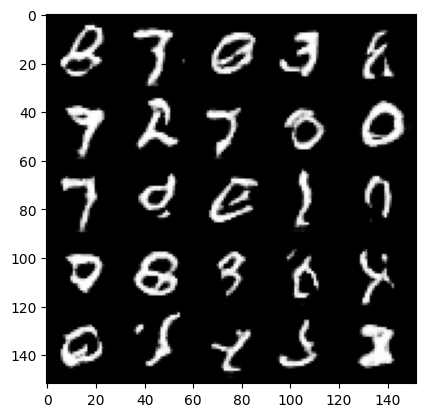

Succecfully save model to MNIST_Generator_epoch_59!
Succecfully save model to MNIST_Critic_epoch_59!
Epoch 60 | Batch 234/469(50%) | Critic Loss: -38.709982 | Generator Loss: 859.063233
Epoch 60 | Batch 468/469(100%) | Critic Loss: -63.254655 | Generator Loss: 1715.581023
Epoch 60 | Critic Loss: -54.649838963297064, Generator Loss: 1719.1439261039943
Epoch 61 | Batch 234/469(50%) | Critic Loss: -105.435103 | Generator Loss: 831.352186
Epoch 61 | Batch 468/469(100%) | Critic Loss: 80.367038 | Generator Loss: 1694.327718
Epoch 61 | Critic Loss: -104.9064134431037, Generator Loss: 1698.344077429539
Epoch 62 | Batch 234/469(50%) | Critic Loss: -91.918066 | Generator Loss: 888.194444
Epoch 62 | Batch 468/469(100%) | Critic Loss: -755.391333 | Generator Loss: 1775.757301
Epoch 62 | Critic Loss: -174.34390880975127, Generator Loss: 1778.958313834185
Epoch 63 | Batch 234/469(50%) | Critic Loss: 11.263537 | Generator Loss: 903.642375
Epoch 63 | Batch 468/469(100%) | Critic Loss: 30.895499 | Gen

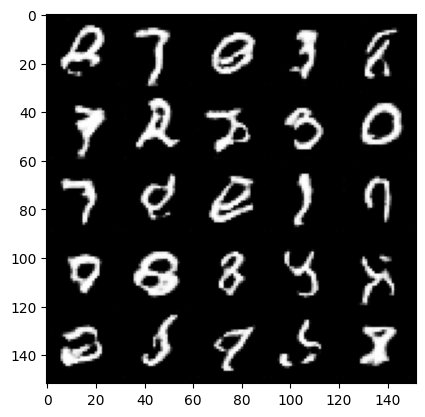

Succecfully save model to MNIST_Generator_epoch_69!
Succecfully save model to MNIST_Critic_epoch_69!
Epoch 70 | Batch 234/469(50%) | Critic Loss: -204.517992 | Generator Loss: 996.311097
Epoch 70 | Batch 468/469(100%) | Critic Loss: -52.839153 | Generator Loss: 2024.669557
Epoch 70 | Critic Loss: -122.18632871326848, Generator Loss: 2029.0221475629658
Epoch 71 | Batch 234/469(50%) | Critic Loss: -40.434814 | Generator Loss: 1013.192954
Epoch 71 | Batch 468/469(100%) | Critic Loss: -377.419678 | Generator Loss: 2026.128480
Epoch 71 | Critic Loss: -62.09089083559731, Generator Loss: 2030.2013951283277
Epoch 72 | Batch 234/469(50%) | Critic Loss: -20.788638 | Generator Loss: 1004.545492
Epoch 72 | Batch 468/469(100%) | Critic Loss: -11.810058 | Generator Loss: 2036.973226
Epoch 72 | Critic Loss: -112.81489817796226, Generator Loss: 2041.4237922066548
Epoch 73 | Batch 234/469(50%) | Critic Loss: 9.402893 | Generator Loss: 1018.470874
Epoch 73 | Batch 468/469(100%) | Critic Loss: -29.782840

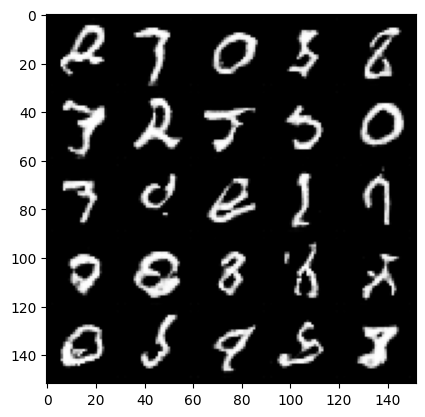

Succecfully save model to MNIST_Generator_epoch_79!
Succecfully save model to MNIST_Critic_epoch_79!
Epoch 80 | Batch 234/469(50%) | Critic Loss: -80.828983 | Generator Loss: 1048.905306
Epoch 80 | Batch 468/469(100%) | Critic Loss: -27.717345 | Generator Loss: 2120.553262
Epoch 80 | Critic Loss: -97.5117356794984, Generator Loss: 2125.0711096009222
Epoch 81 | Batch 234/469(50%) | Critic Loss: -12.571369 | Generator Loss: 1064.491123
Epoch 81 | Batch 468/469(100%) | Critic Loss: -52.781149 | Generator Loss: 2149.612851
Epoch 81 | Critic Loss: -105.19700658926321, Generator Loss: 2154.521129876565
Epoch 82 | Batch 234/469(50%) | Critic Loss: -1130.559277 | Generator Loss: 1078.494090
Epoch 82 | Batch 468/469(100%) | Critic Loss: -152.213213 | Generator Loss: 2164.972218
Epoch 82 | Critic Loss: -135.07945861277548, Generator Loss: 2169.938803211203
Epoch 83 | Batch 234/469(50%) | Critic Loss: 5.810440 | Generator Loss: 1077.953968
Epoch 83 | Batch 468/469(100%) | Critic Loss: 40.086813 |

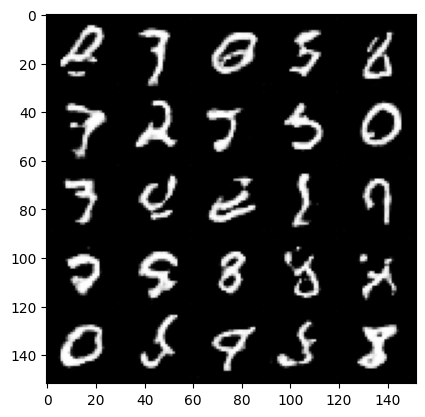

Succecfully save model to MNIST_Generator_epoch_89!
Succecfully save model to MNIST_Critic_epoch_89!
Epoch 90 | Batch 234/469(50%) | Critic Loss: 879.728864 | Generator Loss: 1156.470968
Epoch 90 | Batch 468/469(100%) | Critic Loss: 844.049133 | Generator Loss: 2306.269485
Epoch 90 | Critic Loss: -107.98080933927726, Generator Loss: 2310.7147071041304
Epoch 91 | Batch 234/469(50%) | Critic Loss: 15.404274 | Generator Loss: 1193.957359
Epoch 91 | Batch 468/469(100%) | Critic Loss: 62.609103 | Generator Loss: 2377.916583
Epoch 91 | Critic Loss: -97.07112701981308, Generator Loss: 2382.661073729427
Epoch 92 | Batch 234/469(50%) | Critic Loss: -160.219491 | Generator Loss: 1177.679225
Epoch 92 | Batch 468/469(100%) | Critic Loss: -784.452502 | Generator Loss: 2355.679491
Epoch 92 | Critic Loss: -60.02420018639396, Generator Loss: 2360.7866346281967
Epoch 93 | Batch 234/469(50%) | Critic Loss: 15.728725 | Generator Loss: 1148.436238
Epoch 93 | Batch 468/469(100%) | Critic Loss: -100.978651 

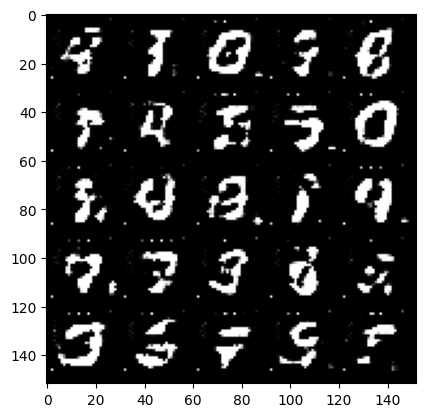

Succecfully save model to MNIST_Generator_epoch_99!
Succecfully save model to MNIST_Critic_epoch_99!
Epoch 100 | Batch 234/469(50%) | Critic Loss: -6411.308008 | Generator Loss: 1688.161916
Epoch 100 | Batch 468/469(100%) | Critic Loss: -3886.850293 | Generator Loss: 3634.746936
Epoch 100 | Critic Loss: -5217.841577955295, Generator Loss: 3645.7618603411515


In [9]:
from torch.utils.tensorboard import SummaryWriter
C_LAMBDA = 10
CRIT_REPEATS = 5
FIXED_NOISES = get_noise(64, 100, device=DEVICE)
Writer = SummaryWriter(log_dir="./logs/GAN/FASHION_MNIST")

def train(generator, critic, gen_opt, crit_opt, dataloader, epoch, print_every=10, writer=None):
    mean_generator_loss = 0
    mean_critic_loss = 0
    generator.train()
    critic.train()
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(DEVICE)

        mean_iteration_critic_loss = 0

        for _ in range(CRIT_REPEATS):
            ### Update critic ###
            crit_opt.zero_grad()
            noise = get_noise(len(real), 100, device=DEVICE)
            fake = generator(noise).detach()
            crit_real = critic(real).reshape(-1)
            crit_fake = critic(fake).reshape(-1)

            gp = gradient_penalty(critic, real, fake, device=DEVICE)
            crit_loss = get_critic_loss(crit_fake, crit_real, gp, C_LAMBDA)
            mean_iteration_critic_loss += crit_loss.item() / CRIT_REPEATS
            crit_opt.zero_grad()
            crit_loss.backward(retain_graph=True)
            crit_opt.step()

        mean_critic_loss += mean_iteration_critic_loss / len(dataloader)

        ### Update generator ###
        gen_opt.zero_grad()
        noise = get_noise(len(real), 100, device=DEVICE)
        fake = generator(noise)
        crit_fake = critic(fake).reshape(-1)
        gen_loss = get_gen_loss(crit_fake)
        mean_generator_loss += gen_loss.item() / len(dataloader)
        gen_loss.backward()
        gen_opt.step()

        if (batch_idx +1) % (len(dataloader)//print_every) == 0:
            print(f"Epoch {epoch} | Batch {batch_idx+1}/{len(dataloader)}({100. * (batch_idx+1) / len(dataloader):.0f}%) | Mean Critic Loss: {mean_iteration_critic_loss/(len(dataloader)//print_every):.6f} | Mean Generator Loss: {mean_generator_loss/(len(dataloader)//print_every):.6f}")

    print(f"Epoch {epoch} | Critic Loss: {mean_critic_loss:.6f}, Generator Loss: {mean_generator_loss:.6f}")
        
    if writer:
        writer.add_scalar('Train/Critic Loss', mean_critic_loss, epoch)
        writer.add_scalar('Train/Generator Loss', mean_generator_loss, epoch)
        

def test(generator, critic, dataloader, epoch, writer=None):
    mean_generator_loss = 0
    mean_critic_loss = 0
    generator.eval()
    critic.eval()

    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(DEVICE)
        noise = get_noise(len(real), 100, device=DEVICE)
        fake = generator(noise)
        crit_real = critic(real).reshape(-1)
        crit_fake = critic(fake).reshape(-1)
        gp = gradient_penalty(critic, real, fake, device=DEVICE)
        crit_loss = get_critic_loss(crit_fake, crit_real, gp, C_LAMBDA)
        mean_critic_loss += crit_loss.item() / len(dataloader)
        gen_loss = get_gen_loss(crit_fake)
        mean_generator_loss += gen_loss.item() / len(dataloader)

    print(f"Test | Epoch {epoch} | Critic Loss: {mean_critic_loss:.6f}, Generator Loss: {mean_generator_loss:.6f}")
        
    if writer:
        writer.add_scalar('Test/Critic Loss', mean_critic_loss, epoch)
        writer.add_scalar('Test/Generator Loss', mean_generator_loss, epoch)
        
    show_tensor_images(generator(FIXED_NOISES))


for epoch in range(1, 101):
    train(netG, netD, netG_opt, netD_opt, mnist_train_loader, epoch, print_every=2, writer=Writer)
    if epoch % 10 == 0:
        test(netG, netD, mnist_test_loader, epoch, writer=Writer)
        save_model(netG, netG_opt, epoch, "MNIST_Generator")
        save_model(netD, netD_opt, epoch, "MNIST_Critic")

Epoch 1 | Batch 234/469(50%) | Mean Critic Loss: -0.075531 | Mean Generator Loss: 0.871249
Epoch 1 | Batch 468/469(100%) | Mean Critic Loss: -0.044304 | Mean Generator Loss: 1.646383
Epoch 1 | Critic Loss: -41.102104, Generator Loss: 386.014302
Epoch 2 | Batch 234/469(50%) | Mean Critic Loss: -0.012098 | Mean Generator Loss: 0.761608
Epoch 2 | Batch 468/469(100%) | Mean Critic Loss: -0.071809 | Mean Generator Loss: 1.542969
Epoch 2 | Critic Loss: -10.469257, Generator Loss: 361.861488
Epoch 3 | Batch 234/469(50%) | Mean Critic Loss: -0.056748 | Mean Generator Loss: 0.795924
Epoch 3 | Batch 468/469(100%) | Mean Critic Loss: -0.005649 | Mean Generator Loss: 1.591550
Epoch 3 | Critic Loss: -13.870185, Generator Loss: 373.186299
Epoch 4 | Batch 234/469(50%) | Mean Critic Loss: -0.240315 | Mean Generator Loss: 0.798541
Epoch 4 | Batch 468/469(100%) | Mean Critic Loss: -0.032629 | Mean Generator Loss: 1.605140
Epoch 4 | Critic Loss: -17.669154, Generator Loss: 376.388736
Epoch 5 | Batch 234/

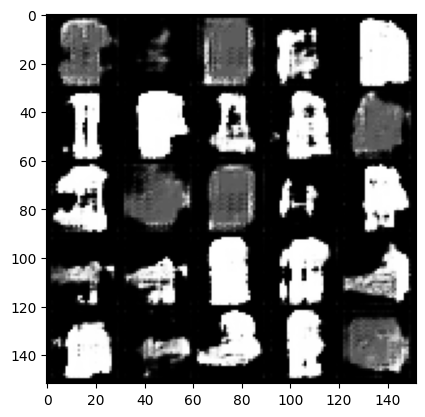

Epoch 6 | Batch 234/469(50%) | Mean Critic Loss: -0.021898 | Mean Generator Loss: 0.352887
Epoch 6 | Batch 468/469(100%) | Mean Critic Loss: -0.285139 | Mean Generator Loss: 0.699056
Epoch 6 | Critic Loss: -10.442740, Generator Loss: 164.263044
Epoch 7 | Batch 234/469(50%) | Mean Critic Loss: 0.003077 | Mean Generator Loss: 0.364989
Epoch 7 | Batch 468/469(100%) | Mean Critic Loss: 3.070585 | Mean Generator Loss: 0.771386
Epoch 7 | Critic Loss: -25.177086, Generator Loss: 181.146861
Epoch 8 | Batch 234/469(50%) | Mean Critic Loss: -0.056676 | Mean Generator Loss: 0.419908
Epoch 8 | Batch 468/469(100%) | Mean Critic Loss: 0.022857 | Mean Generator Loss: 0.793148
Epoch 8 | Critic Loss: -34.791082, Generator Loss: 185.958640
Epoch 9 | Batch 234/469(50%) | Mean Critic Loss: -0.090819 | Mean Generator Loss: 0.417354
Epoch 9 | Batch 468/469(100%) | Mean Critic Loss: -0.167678 | Mean Generator Loss: 0.975517
Epoch 9 | Critic Loss: -44.084491, Generator Loss: 229.040779
Epoch 10 | Batch 234/46

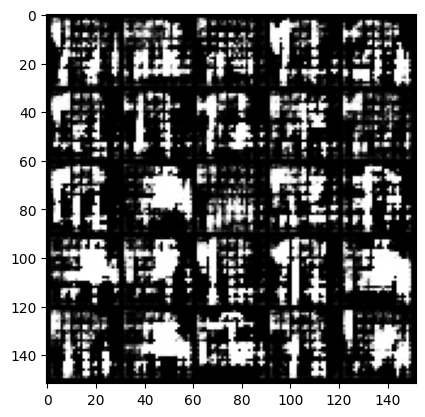

Succecfully save model to MNIST_Generator_FASHION_epoch_10!
Succecfully save model to MNIST_Critic_FASHION_epoch_10!
Epoch 11 | Batch 234/469(50%) | Mean Critic Loss: -0.388452 | Mean Generator Loss: 0.758757
Epoch 11 | Batch 468/469(100%) | Mean Critic Loss: -3.810364 | Mean Generator Loss: 1.513271
Epoch 11 | Critic Loss: -90.488991, Generator Loss: 354.805169
Epoch 12 | Batch 234/469(50%) | Mean Critic Loss: -0.188749 | Mean Generator Loss: 0.618749
Epoch 12 | Batch 468/469(100%) | Mean Critic Loss: -10.659572 | Mean Generator Loss: 1.226127
Epoch 12 | Critic Loss: -954.693470, Generator Loss: 287.595516
Epoch 13 | Batch 234/469(50%) | Mean Critic Loss: 1.873850 | Mean Generator Loss: 0.370100
Epoch 13 | Batch 468/469(100%) | Mean Critic Loss: 0.211240 | Mean Generator Loss: 0.522668
Epoch 13 | Critic Loss: -308.308766, Generator Loss: 122.626217
Epoch 14 | Batch 234/469(50%) | Mean Critic Loss: 0.785230 | Mean Generator Loss: 0.435208
Epoch 14 | Batch 468/469(100%) | Mean Critic Lo

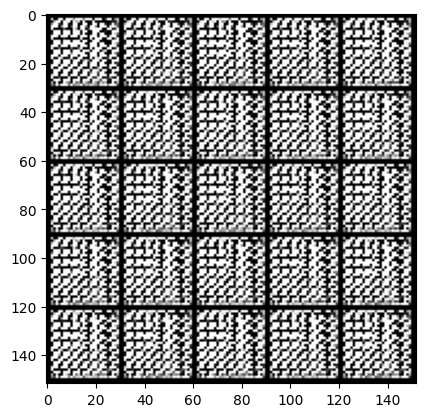

Epoch 16 | Batch 234/469(50%) | Mean Critic Loss: -18.370463 | Mean Generator Loss: -0.575067
Epoch 16 | Batch 468/469(100%) | Mean Critic Loss: -18.565866 | Mean Generator Loss: -1.004570
Epoch 16 | Critic Loss: -4008.931446, Generator Loss: -235.188596
Epoch 17 | Batch 234/469(50%) | Mean Critic Loss: -21.786074 | Mean Generator Loss: -0.318594
Epoch 17 | Batch 468/469(100%) | Mean Critic Loss: -12.434390 | Mean Generator Loss: -1.479628
Epoch 17 | Critic Loss: -3722.703190, Generator Loss: -347.935729
Epoch 18 | Batch 234/469(50%) | Mean Critic Loss: -23.381712 | Mean Generator Loss: -2.213914
Epoch 18 | Batch 468/469(100%) | Mean Critic Loss: -32.600629 | Mean Generator Loss: -4.962287
Epoch 18 | Critic Loss: -5937.649781, Generator Loss: -1164.115069
Epoch 19 | Batch 234/469(50%) | Mean Critic Loss: -37.552758 | Mean Generator Loss: -2.859580
Epoch 19 | Batch 468/469(100%) | Mean Critic Loss: -37.872807 | Mean Generator Loss: -7.348061
Epoch 19 | Critic Loss: -7749.421009, Generat

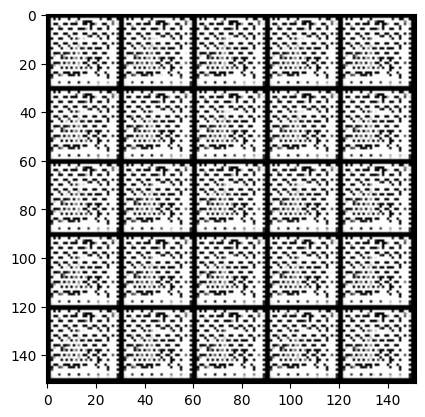

Succecfully save model to MNIST_Generator_FASHION_epoch_20!
Succecfully save model to MNIST_Critic_FASHION_epoch_20!
Epoch 21 | Batch 234/469(50%) | Mean Critic Loss: -36.442911 | Mean Generator Loss: -7.948379
Epoch 21 | Batch 468/469(100%) | Mean Critic Loss: -48.333598 | Mean Generator Loss: -17.560547
Epoch 21 | Critic Loss: -9998.003517, Generator Loss: -4118.979226
Epoch 22 | Batch 234/469(50%) | Mean Critic Loss: -59.237320 | Mean Generator Loss: -9.435565
Epoch 22 | Batch 468/469(100%) | Mean Critic Loss: -65.447799 | Mean Generator Loss: -19.139853
Epoch 22 | Critic Loss: -12780.320255, Generator Loss: -4488.594423
Epoch 23 | Batch 234/469(50%) | Mean Critic Loss: -69.995307 | Mean Generator Loss: -9.821425
Epoch 23 | Batch 468/469(100%) | Mean Critic Loss: -85.219069 | Mean Generator Loss: -19.597059
Epoch 23 | Critic Loss: -16079.266317, Generator Loss: -4595.200979
Epoch 24 | Batch 234/469(50%) | Mean Critic Loss: -92.847294 | Mean Generator Loss: -9.527859
Epoch 24 | Batch

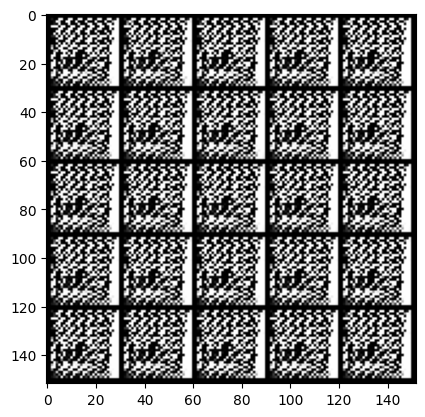

Epoch 26 | Batch 234/469(50%) | Mean Critic Loss: -123.269974 | Mean Generator Loss: -11.890538


KeyboardInterrupt: 

In [34]:
from torch.utils.tensorboard import SummaryWriter
C_LAMBDA = 10
CRIT_REPEATS = 5
FIXED_NOISES = get_noise(64, 100, device=DEVICE)
Writer = SummaryWriter(log_dir="./logs/GAN/FASHION_MNIST")

def train(generator, critic, gen_opt, crit_opt, dataloader, epoch, print_every=10, writer=None):
    mean_generator_loss = 0
    mean_critic_loss = 0
    generator.train()
    critic.train()
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(DEVICE)

        mean_iteration_critic_loss = 0

        for _ in range(CRIT_REPEATS):
            ### Update critic ###
            crit_opt.zero_grad()
            noise = get_noise(len(real), 100, device=DEVICE)
            fake = generator(noise).detach()
            crit_real = critic(real).reshape(-1)
            crit_fake = critic(fake).reshape(-1)

            gp = gradient_penalty(critic, real, fake, device=DEVICE)
            crit_loss = get_critic_loss(crit_fake, crit_real, gp, C_LAMBDA)
            mean_iteration_critic_loss += crit_loss.item() / CRIT_REPEATS
            crit_opt.zero_grad()
            crit_loss.backward(retain_graph=True)
            crit_opt.step()

        mean_critic_loss += mean_iteration_critic_loss / len(dataloader)

        ### Update generator ###
        gen_opt.zero_grad()
        noise = get_noise(len(real), 100, device=DEVICE)
        fake = generator(noise)
        crit_fake = critic(fake).reshape(-1)
        gen_loss = get_gen_loss(crit_fake)
        mean_generator_loss += gen_loss.item() / len(dataloader)
        gen_loss.backward()
        gen_opt.step()

        if (batch_idx +1) % (len(dataloader)//print_every) == 0:
            print(f"Epoch {epoch} | Batch {batch_idx+1}/{len(dataloader)}({100. * (batch_idx+1) / len(dataloader):.0f}%) | Mean Critic Loss: {mean_iteration_critic_loss/(len(dataloader)//print_every):.6f} | Mean Generator Loss: {mean_generator_loss/(len(dataloader)//print_every):.6f}")

    print(f"Epoch {epoch} | Critic Loss: {mean_critic_loss:.6f}, Generator Loss: {mean_generator_loss:.6f}")
        
    if writer:
        writer.add_scalar('Train/Critic Loss', mean_critic_loss, epoch)
        writer.add_scalar('Train/Generator Loss', mean_generator_loss, epoch)
        

def test(generator, critic, dataloader, epoch, writer=None):
    mean_generator_loss = 0
    mean_critic_loss = 0
    generator.eval()
    critic.eval()

    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(DEVICE)
        noise = get_noise(len(real), 100, device=DEVICE)
        fake = generator(noise)
        crit_real = critic(real).reshape(-1)
        crit_fake = critic(fake).reshape(-1)
        gp = gradient_penalty(critic, real, fake, device=DEVICE)
        crit_loss = get_critic_loss(crit_fake, crit_real, gp, C_LAMBDA)
        mean_critic_loss += crit_loss.item() / len(dataloader)
        gen_loss = get_gen_loss(crit_fake)
        mean_generator_loss += gen_loss.item() / len(dataloader)

    print(f"Test | Epoch {epoch} | Critic Loss: {mean_critic_loss:.6f}, Generator Loss: {mean_generator_loss:.6f}")
        
    if writer:
        writer.add_scalar('Test/Critic Loss', mean_critic_loss, epoch)
        writer.add_scalar('Test/Generator Loss', mean_generator_loss, epoch)
        
    show_tensor_images(generator(FIXED_NOISES))


for epoch in range(1, 51):
    train(netG, netD, netG_opt, netD_opt, fashion_train_loader, epoch, print_every=2, writer=Writer)

    if epoch % 5 == 0:
        show_tensor_images(netG(FIXED_NOISES))
    if epoch % 10 == 0:
        save_model(netG, netG_opt, epoch, "MNIST_Generator_FASHION")
        save_model(netD, netD_opt, epoch, "MNIST_Critic_FASHION")